## **PART 1**

##### **Grab Data**

In [1]:
import requests  #to send HTTP requests and fetch the webpage.
from bs4 import BeautifulSoup #to parse HTML and extract data.
import pandas as pd 
import numpy as np
import random
import bisect
import collections
import matplotlib.pyplot as plt
import seaborn as sns

# store the URL in a variable
url = 'https://oldschool.runescape.wiki/w/Zulrah'

# access the contents of the webpage
#response = requests.get(url, headers= {'User-Agent': 'Mozilla/5.0'})
response = requests.get(url, headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/115.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
    "Referer": "https://www.google.com/"
})

# extract HTML from response
page_content = response.content

# parse HTML
soup = BeautifulSoup(page_content, 'lxml')

# find all tables in the HTML
my_tables = soup.find_all('table', attrs = {"class": "wikitable sortable filterable item-drops autosort=4,a"})

#initialize dictionary to store tables
loot_tables = {}
table_index = 0

for table in my_tables:
    # Parse out table rows
    table_rows = table.find_all('tr')

    # Parse out the table header
    table_header = table.find_all('th')

    # Parse columns from table header
    cols = []
    for item in table_header:
        if len(item.text) > 0:
            cols.append(item.text)

    # Parse data for each row
    data = []
    for row in table_rows:
        table_data = row.find_all('td')
        row_data = [item.text for item in table_data if item.text != '']
        if len(row_data) > 0:
            data.append(row_data)

    #print(data)
    #print(cols)
    output_frame = pd.DataFrame(data, columns=cols)

    loot_tables.setdefault(table_index, output_frame)

    table_index += 1
    

In [2]:
loot_table = pd.concat(loot_tables.values())
loot_table.set_index('Item', inplace=True)
loot_table

,Quantity,Rarity,Price,High Alch
Item,,,,
Zulrah's scales,100–299,Always,"17,100–51,129","1,200–3,588"
Tanzanite fang,1,"2 × 1/1,024","7,280,408","66,000"
Magic fang,1,"2 × 1/1,024","3,366,110","61,200"
Serpentine visage,1,"2 × 1/1,024","3,352,104","63,000"
Uncut onyx,1,"2 × 1/1,024","1,922,963","120,000"
...,...,...,...,...
Rune javelin,5,"2 × 1/20,398.08; 1/10,358.4[d 2]",635,"1,200"
Brimstone key,1,1/50[d 1],Not sold,N/A
Clue scroll (elite),1,1/75[d 2][d 3][5],Not sold,12


## **PART 2**

### **Data Cleaning**

In [3]:
import re

def parse_range(value):
    """Convert a range like '100–299' to its average, or single value to int."""
    if pd.isna(value):
        return np.nan
    value = value.replace(',', '').strip()
    if 'Not sold' in value or 'N/A' in value:
        return np.nan
    # Match numbers
    nums = re.findall(r'\d+', value)
    if not nums:
        return np.nan
    nums = list(map(int, nums))
    return np.mean(nums) if len(nums) > 1 else nums[0]

# Apply to numeric columns
for col in ['Quantity', 'Price', 'High Alch']:
    loot_table[col] = loot_table[col].apply(parse_range)


In [4]:
loot_table_sorted = loot_table.sort_values(by='Price', ascending=False)
print(loot_table_sorted.head(10))

                   Quantity       Rarity      Price  High Alch
Item                                                          
Tanzanite fang          1.0  2 × 1/1,024  7280408.0    66000.0
Magic fang              1.0  2 × 1/1,024  3366110.0    61200.0
Serpentine visage       1.0  2 × 1/1,024  3352104.0    63000.0
Uncut onyx              1.0  2 × 1/1,024  1922963.0   120000.0
Dragon halberd          1.0    2 × 2/249   149669.0   150000.0
Snapdragon             10.0    2 × 2/249   126740.0      350.0
Toadflax               25.0    2 × 2/249   108575.0      700.0
Dwarf weed             30.0    2 × 2/249   105090.0     1260.0
Zulrah's scales       500.0    2 × 5/249    85500.0     6000.0
Battlestaff            10.0   2 × 10/249    85330.0    42000.0


In [5]:
rare_drops = loot_table[loot_table['Rarity'].str.contains('1/1,0', na=False)]
print(rare_drops)


                   Quantity                           Rarity      Price  \
Item                                                                      
Tanzanite fang          1.0                      2 × 1/1,024  7280408.0   
Magic fang              1.0                      2 × 1/1,024  3366110.0   
Serpentine visage       1.0                      2 × 1/1,024  3352104.0   
Uncut onyx              1.0                      2 × 1/1,024  1922963.0   
Nature rune            67.0                    2 × 1/1,062.4     5896.0   
Rune 2h sword           1.0                    2 × 1/1,062.4    38048.0   
Rune battleaxe          1.0                    2 × 1/1,062.4    24604.0   
Dragon spear            1.0  2 × 1/8,972.35; 1/1,041.05[d 2]    37261.0   

                   High Alch  
Item                          
Tanzanite fang       66000.0  
Magic fang           61200.0  
Serpentine visage    63000.0  
Uncut onyx          120000.0  
Nature rune           7236.0  
Rune 2h sword        38400.0  
R

In [6]:
# ---------- STEP 1: CLEANING FUNCTIONS ----------
def parse_range(value):
    """Convert a range like '100–299' to its average, or single value to int."""
    if pd.isna(value):
        return np.nan
    value = str(value).replace(',', '').strip()  # ensure string
    if 'Not sold' in value or 'N/A' in value:
        return np.nan
    nums = re.findall(r'\d+', value)
    if not nums:
        return np.nan
    nums = list(map(int, nums))
    return np.mean(nums) if len(nums) > 1 else nums[0]

def parse_probability(rarity):
    """Convert rarity strings like '1/1024' or '2 × 1/1024' to probability."""
    if pd.isna(rarity):
        return np.nan
    rarity = str(rarity)
    match = re.search(r'(\d+)\s*×\s*1/(\d+)', rarity)
    if match:
        count, denom = map(int, match.groups())
        return count / denom
    match = re.search(r'1/(\d+)', rarity)
    if match:
        denom = int(match.group(1))
        return 1 / denom
    return np.nan

# ---------- STEP 2: APPLY CLEANING ----------
for col in ['Quantity', 'Price', 'High Alch']:
    loot_table[col] = loot_table[col].apply(parse_range)

loot_table['Drop Prob'] = loot_table['Rarity'].apply(parse_probability)

# Optional: Add categories manually (extend as needed)
category_map = {
    "Zulrah's scales": "Consumable",
    "Tanzanite fang": "Unique",
    "Magic fang": "Unique",
    "Serpentine visage": "Unique",
    "Uncut onyx": "Unique",
}
loot_table['Category'] = loot_table.index.map(lambda x: category_map.get(x, 'Other'))

# ---------- STEP 3: VISUALISATIONS ----------
sns.set(style="whitegrid", palette="viridis")


## **PART 3**

### **Data Visualization**

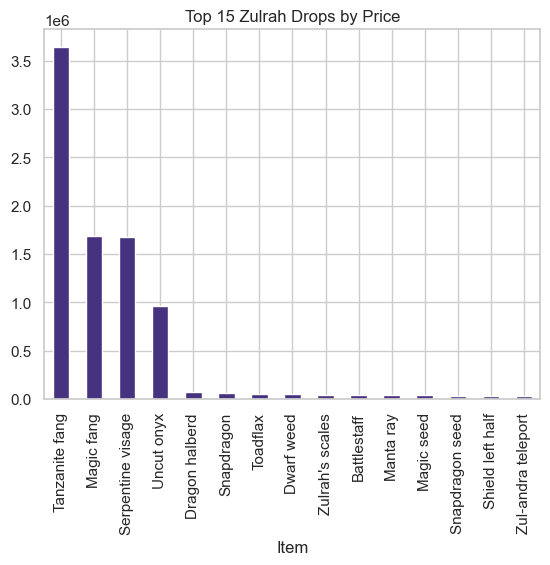

In [7]:
loot_table['Price'].nlargest(15).plot(kind='bar')
plt.title('Top 15 Zulrah Drops by Price')
plt.show()


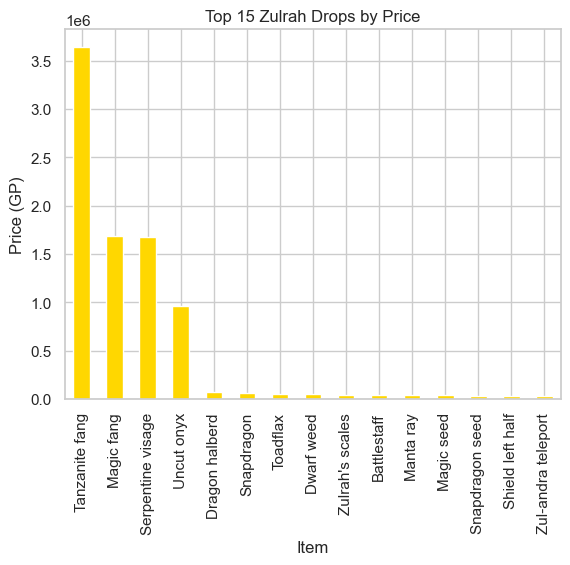

In [8]:
loot_table['Price'] = pd.to_numeric(loot_table['Price'], errors='coerce')
loot_table['Price'].nlargest(15).plot(kind='bar', color='gold')
plt.title('Top 15 Zulrah Drops by Price')
plt.ylabel('Price (GP)')
plt.show()


C:\Users\hdsin\AppData\Local\Temp\ipykernel_16920\1286911255.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_items.values, y=top_items.index, palette="viridis")


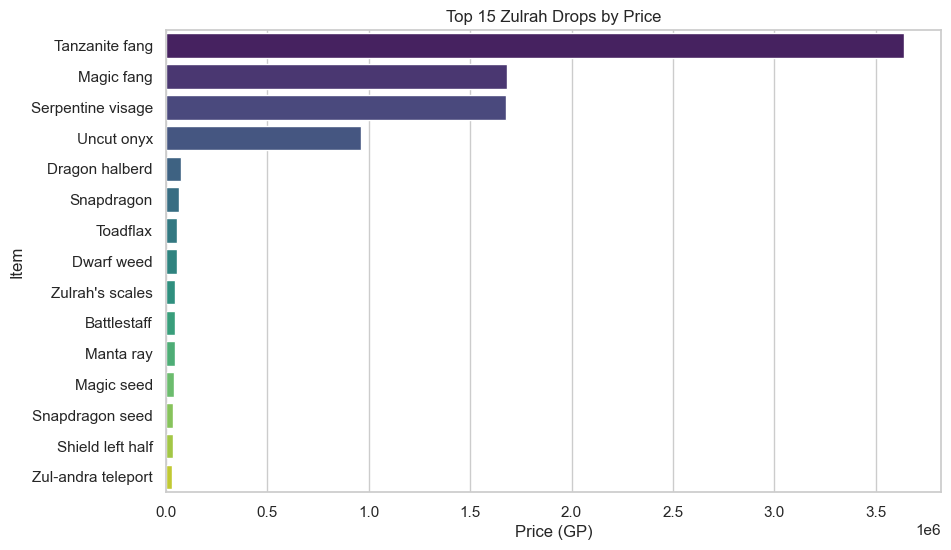

In [9]:
# Top 15 Drops by Price
plt.figure(figsize=(10,6))
top_items = loot_table['Price'].nlargest(15)
sns.barplot(x=top_items.values, y=top_items.index, palette="viridis")
plt.title("Top 15 Zulrah Drops by Price")
plt.xlabel("Price (GP)")
plt.ylabel("Item")
plt.show()

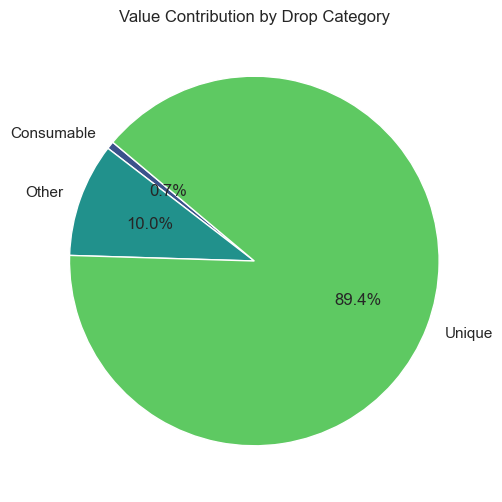

In [10]:
# Value Contribution by Category
plt.figure(figsize=(6,6))
category_totals = loot_table.groupby('Category')['Price'].sum()
category_totals.plot(kind='pie', autopct='%1.1f%%', startangle=140,
                     colors=sns.color_palette("viridis", len(category_totals)))
plt.title("Value Contribution by Drop Category")
plt.ylabel("")
plt.show()

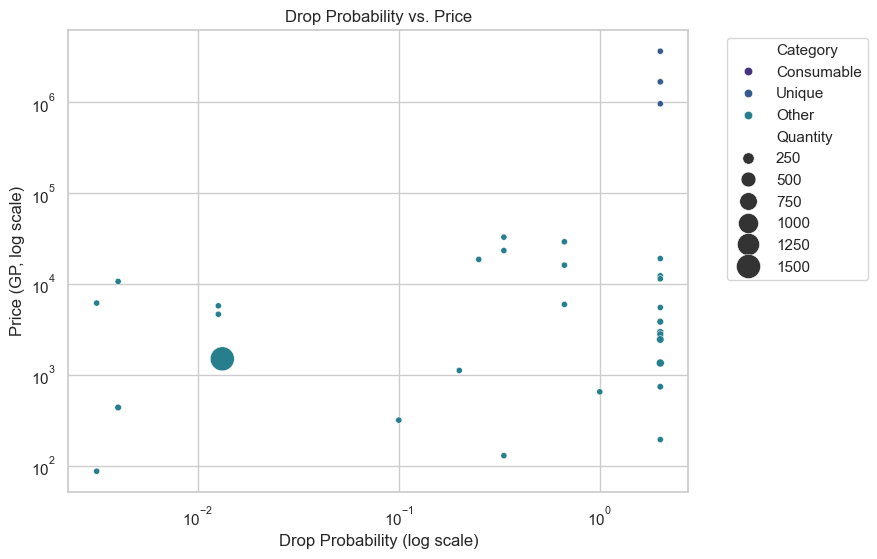

In [11]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=loot_table.reset_index(),  # reset to avoid duplicate index issue
    x='Drop Prob', y='Price',
    size='Quantity', hue='Category', sizes=(20, 300)
)
plt.xscale('log')
plt.yscale('log')
plt.title("Drop Probability vs. Price")
plt.xlabel("Drop Probability (log scale)")
plt.ylabel("Price (GP, log scale)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


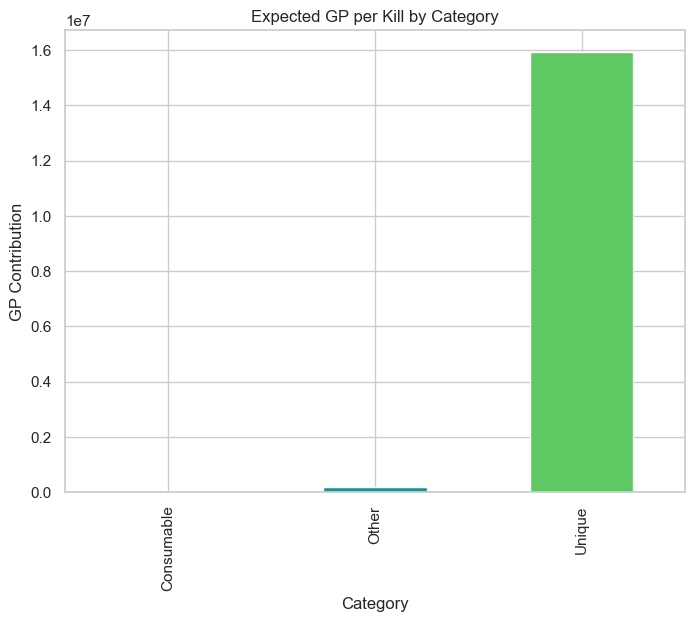

In [12]:
# Expected GP per Kill by Category
loot_table['GP Contribution'] = loot_table['Price'] * loot_table['Drop Prob']
gp_by_category = loot_table.groupby('Category')['GP Contribution'].sum()
plt.figure(figsize=(8,6))
gp_by_category.plot(kind='bar', color=sns.color_palette("viridis", len(gp_by_category)))
plt.title("Expected GP per Kill by Category")
plt.ylabel("GP Contribution")
plt.show()